In [311]:
# Try loading fMRI using nilearn

from nilearn import image
from nilearn import plotting

subdir = '/home/anton/Documents/Tulane/Hackathon/ds004144-out/sub-005/func'
imgname = 'sub-005_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
# imgname = 'sub-003_task-epr_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'

img = image.load_img(f'{subdir}/{imgname}')

print(img.shape)

(65, 77, 65, 300)


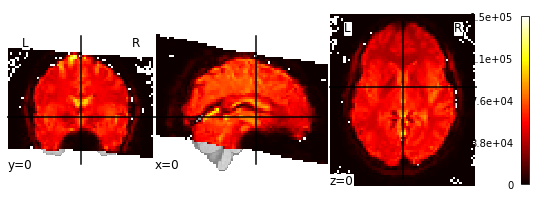

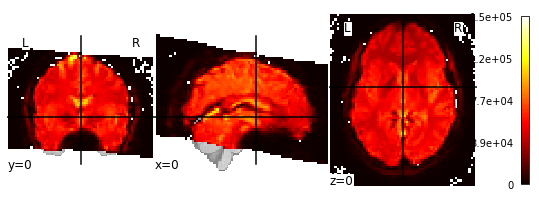

In [312]:
img_vol0_2 = image.index_img(img, slice(0,2))

for vol in image.iter_img(img_vol0_2):
    plotting.plot_stat_map(vol, cut_coords=(0,0,0))

In [313]:
# Load power template coords

powerfile = '/home/anton/Documents/Tulane/Hackathon/power264/power264MNI.nii.gz'

powerimg = image.load_img(powerfile)

print(powerimg.shape)

(91, 109, 91)


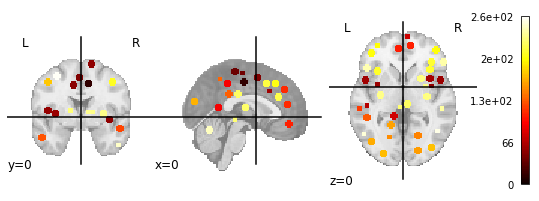

In [283]:
plotting.plot_stat_map(powerimg, cut_coords=(0,0,0))

In [284]:
# Load ROI coordinates

import re

# Radius 5
pat = re.compile('.*Power(\d+)([^#]+)#(-?\d+,-?\d+,-?\d+).*')

def parseLine(pat, line):
    res = pat.search(line)
    if res:
        idx, bfn, mni = res.groups()
        mni = np.array([int(coord) for coord in mni.split(',')]+[1])
        return (idx,bfn,mni)
    return None

roifile = '/home/anton/Documents/Tulane/Hackathon/power264/power264CoorMNI.sclib'
rois = []

with open(roifile, 'r') as f:
    for line in f.readlines():
        p = parseLine(pat, line)
        rois.append(p)

rois = [p for p in rois if p is not None]
print(len(rois))

264


[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]


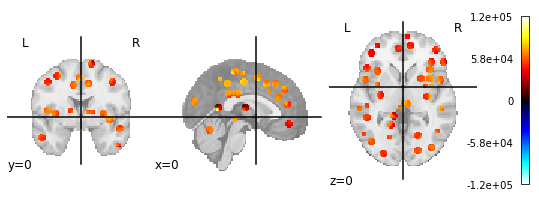

In [314]:
vol0 = image.index_img(img, 1)
vol0_resamp = image.resample_to_img(vol0, powerimg)
vol0_rois = image.math_img('(img1 > 0)*img2', img1=powerimg, img2=vol0_resamp)
print(vol0_rois.affine)
plotting.plot_stat_map(vol0_rois, cut_coords=(0,0,0))

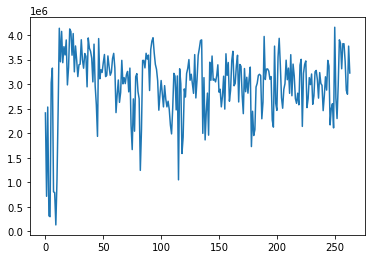

In [315]:
import matplotlib.pyplot as plt

invaff = np.linalg.inv(powerimg.affine)
signal = np.zeros(len(rois))

for i,roi in enumerate(rois):
    x,y,z,_ = np.floor(invaff@roi[-1]).astype('int')
#     print((x,y,z))
    signal[i] = np.sum(vol0_rois.get_fdata()[x-2:x+2,y-2:y+2,z-2:z+2])
    
plt.plot(signal)
plt.show()

In [316]:
def getRoiImage(img, powerimg, tp):
    vol = image.index_img(img, tp)
    vol_resamp = image.resample_to_img(vol, powerimg)
    vol_rois = image.math_img('(img1 > 0)*img2', img1=powerimg, img2=vol_resamp)
    return vol_rois
    
def extractSignal(volRoiImg, rois, invXfrom):
    signal = np.zeros(len(rois))

    for i,roi in enumerate(rois):
        x,y,z,_ = np.floor(invaff@roi[-1]).astype('int')
        signal[i] = np.sum(volRoiImg.get_fdata()[x-2:x+2,y-2:y+2,z-2:z+2])
        
    return signal

allSignal = np.zeros((264,img.shape[-1]))
invaff = np.linalg.inv(powerimg.affine)

for tp in range(img.shape[-1]):
    volImg = getRoiImage(img, powerimg, tp)
    allSignal[:,tp] = extractSignal(volImg, rois, invaff)
    if tp%10 == 0:
        print(f'Completed {tp}')

print('Done')

Completed 0
Completed 10
Completed 20
Completed 30
Completed 40
Completed 50
Completed 60
Completed 70
Completed 80
Completed 90
Completed 100
Completed 110
Completed 120
Completed 130
Completed 140
Completed 150
Completed 160
Completed 170
Completed 180
Completed 190
Completed 200
Completed 210
Completed 220
Completed 230
Completed 240
Completed 250
Completed 260
Completed 270
Completed 280
Completed 290
Done


In [329]:
from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

filtSignal = butter_bandpass_filter(allSignal, np.array([img.shape[-1]/30,3/4*img.shape[-1]]), 2200)
print(filtSignal.shape)

(264, 300)


In [319]:
filtSignal = allSignal

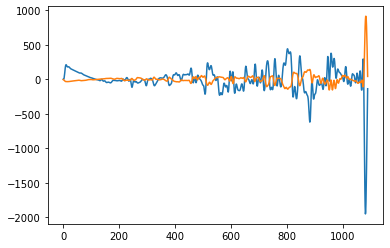

In [290]:
plt.plot(filtSignal[140:142,:].T)
plt.show()

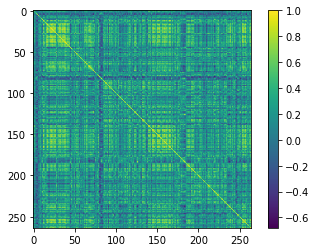

In [330]:
p = np.corrcoef(filtSignal)

plt.imshow(p)
plt.colorbar()
plt.show()

[[   1.    0.    0.  -90.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]


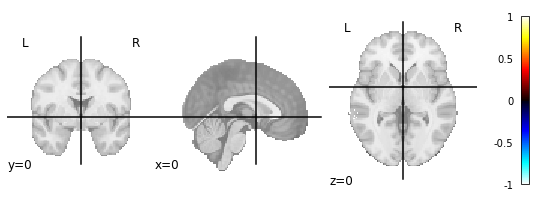

In [85]:
from scipy.ndimage import affine_transform
from nibabel.nifti1 import Nifti1Image

res = affine_transform((powerimg.get_fdata() > 0).astype('float'), powerimg.affine) #*powerimg.dataobj@powerimg.affine
new_affine = np.eye(4)
new_affine[:,-1] = [-90,-126,-72,1]
res.shape
res = Nifti1Image(res, new_affine)
print(res.affine)

plotting.plot_stat_map(res, cut_coords=(0,0,0))

In [100]:
testimg = np.array([[[1,2,3],[4,5,6],[7,8,9]]])
idcs = np.argsort(affine_transform(testimg, powerimg.affine, output_shape=(100,100,100)))

TypeError: _argsort_dispatcher() got an unexpected keyword argument 'reverse'

In [95]:
powerimg.affine

array([[  -2.,    0.,    0.,   90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])

In [70]:
np.sum(powerimg.get_fdata() > 0)/264*2

162.0

In [88]:
(powerimg.get_fdata() > 0).astype('float').shape

(91, 109, 91)